## [Template to transfer datetime](#Template_to_transfer_datetime)
## [EDA](#EDA_)
## [Prophet](#Prophet_)
## [Using Prophet to make predictions](#Using_Prophet_to_make_predictions_in_the_future_)
##  [Statistics Model](#Statistics_Model)
##  [Prophet](#Prophet_)
##  [ARIMA](#ARIMA_)

## USeful link
1. [ARIMA Model ](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
2. [Time series in python](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
3. [VAR model(Multivariate Time Series Analysis)](https://towardsdatascience.com/multivariate-time-series-forecasting-456ace675971)
4. [Time series modeling with Facebook Prophet](https://towardsdatascience.com/time-series-modeling-with-facebook-prophet-57f146a11d0d)
5. [ARIMA/Sarima与LSTM的时间序列数据集成学习](https://bbs.huaweicloud.com/blogs/108318)
6. [Prophet](https://github.com/facebook/prophet)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import datetime
import statsmodels.api as sm
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

In [4]:
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


In [6]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

Variable     count of unique value    content
date                   204	 [numpy.datetime64('1991-07-01T00:00:00.000000000'), numpy.datetime64('1991-08-01T00:00:00.000000000'), numpy.datetime64('1991-09-01T00:00:00.000000000'), numpy.datetime64('1991-10-01T00:00:00.000000000'), numpy.datetime64('1991-11-01T00:00:00.000000000')]
value                  204	 [2.81452, 2.985811, 3.1275779999999997, 3.180891, 3.20478]


In [7]:
#df['date'] = pd.to_datetime(df["date"], format="%Y-%m-%dT%H:%M:%S.%fZ")
df['date'] = pd.to_datetime(df["date"], format="%Y-%m-%dT")

<AxesSubplot:xlabel='date', ylabel='value'>

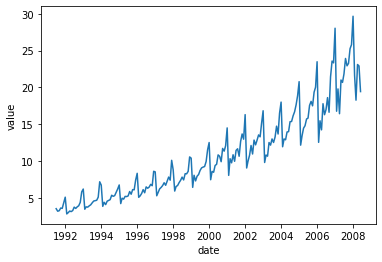

In [8]:
sns.lineplot(data=df, x=df.date, y=df.value)

In [7]:
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


## Template to transfer datetime

<a id='Template_to_transfer_datetime'></a>

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df["date"], format="%Y%m%d") 
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='value')
features_and_target = pd.concat([X, y, df.date], axis=1)
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,value,date
0,0,0,3,7,1991,182,1,27,3.526591,1991-07-01
1,0,3,3,8,1991,213,1,31,3.180891,1991-08-01
2,0,6,3,9,1991,244,1,35,3.252221,1991-09-01
3,0,1,4,10,1991,274,1,40,3.611003,1991-10-01
4,0,4,4,11,1991,305,1,44,3.565869,1991-11-01
...,...,...,...,...,...,...,...,...,...,...
199,0,4,1,2,2008,32,1,5,21.654285,2008-02-01
200,0,5,1,3,2008,61,1,9,18.264945,2008-03-01
201,0,1,2,4,2008,92,1,14,23.107677,2008-04-01
202,0,3,2,5,2008,122,1,18,22.912510,2008-05-01


# EDA

<a id='EDA_'></a>

### Visualizing a time series

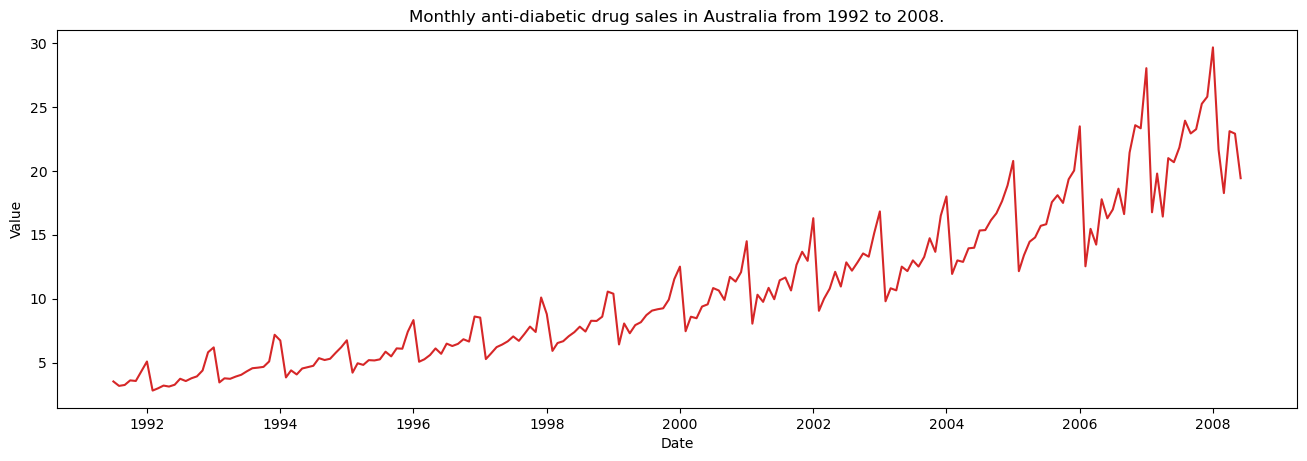

In [9]:
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')  

## Seasonal Plot of a Time Series

<a id='Seasonal Plot of a Time Series'></a>

In [139]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
# df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()
print(years)
df

[1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008]


,value,year,month
date,,,
1991-07-01,3.526591,1991,Jul
1991-08-01,3.180891,1991,Aug
1991-09-01,3.252221,1991,Sep
1991-10-01,3.611003,1991,Oct
1991-11-01,3.565869,1991,Nov
...,...,...,...
2008-02-01,21.654285,2008,Feb
2008-03-01,18.264945,2008,Mar
2008-04-01,23.107677,2008,Apr


In [140]:
df_2007 = df[df["year"] == 2007]
df_2007

,value,year,month
date,,,
2007-01-01,28.038383,2007,Jan
2007-02-01,16.763869,2007,Feb
2007-03-01,19.792754,2007,Mar
2007-04-01,16.427305,2007,Apr
2007-05-01,21.000742,2007,May
2007-06-01,20.681002,2007,Jun
2007-07-01,21.834890,2007,Jul
2007-08-01,23.930204,2007,Aug
2007-09-01,22.930357,2007,Sep


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


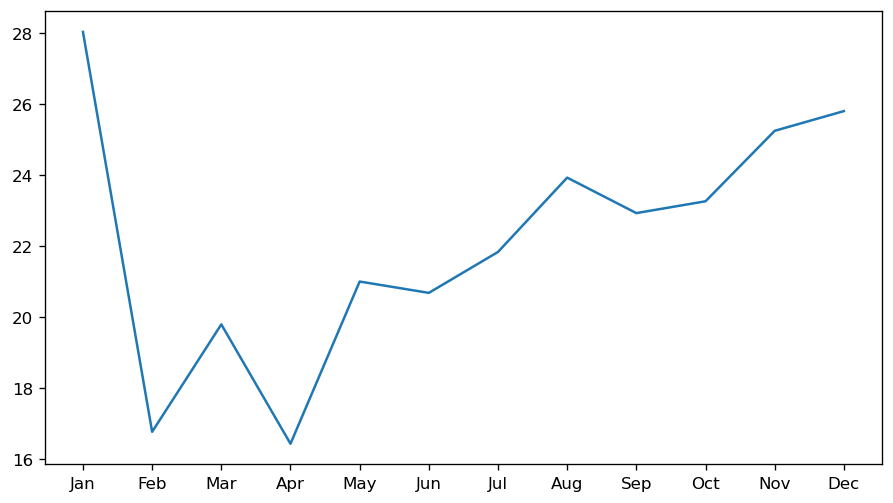

In [141]:
plt.plot('month', 'value', data=df_2007)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

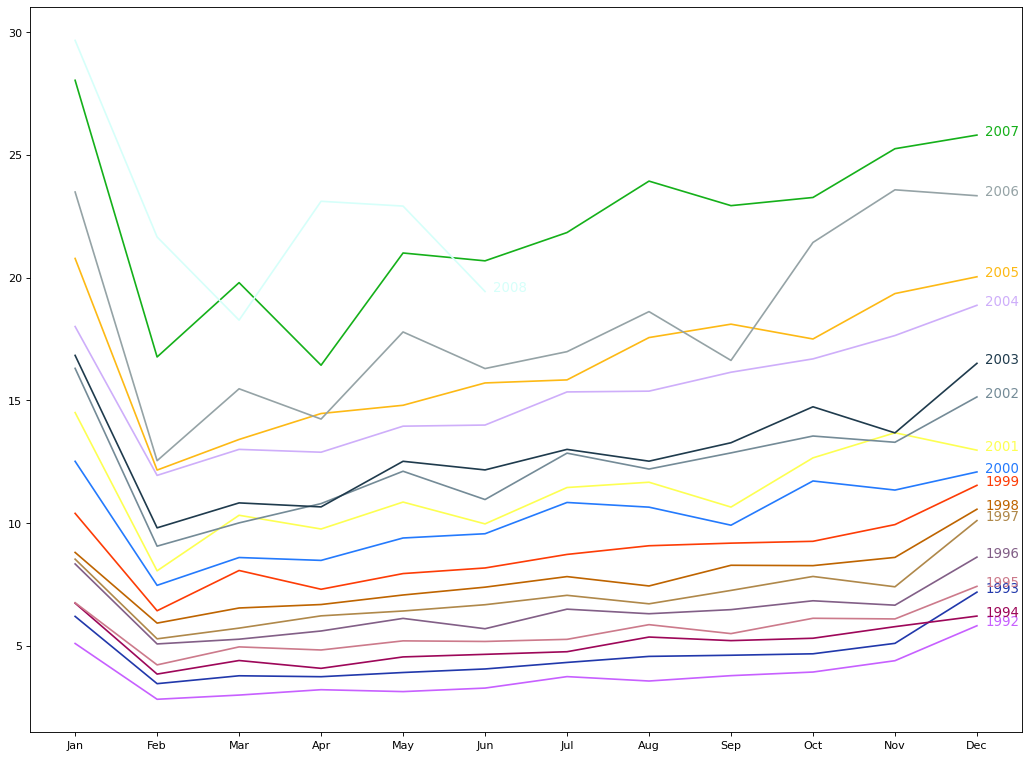

In [142]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

## Box plot

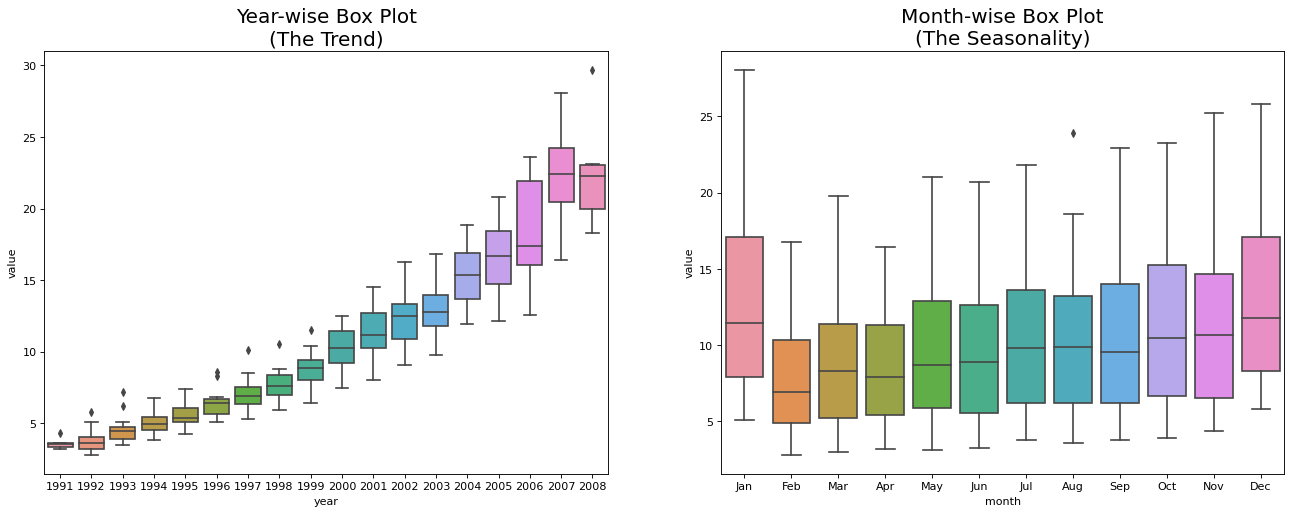

In [143]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

#ylabel='Thousands of Persons'
#xlabel=''
#ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

## Plotting the Features to see trends

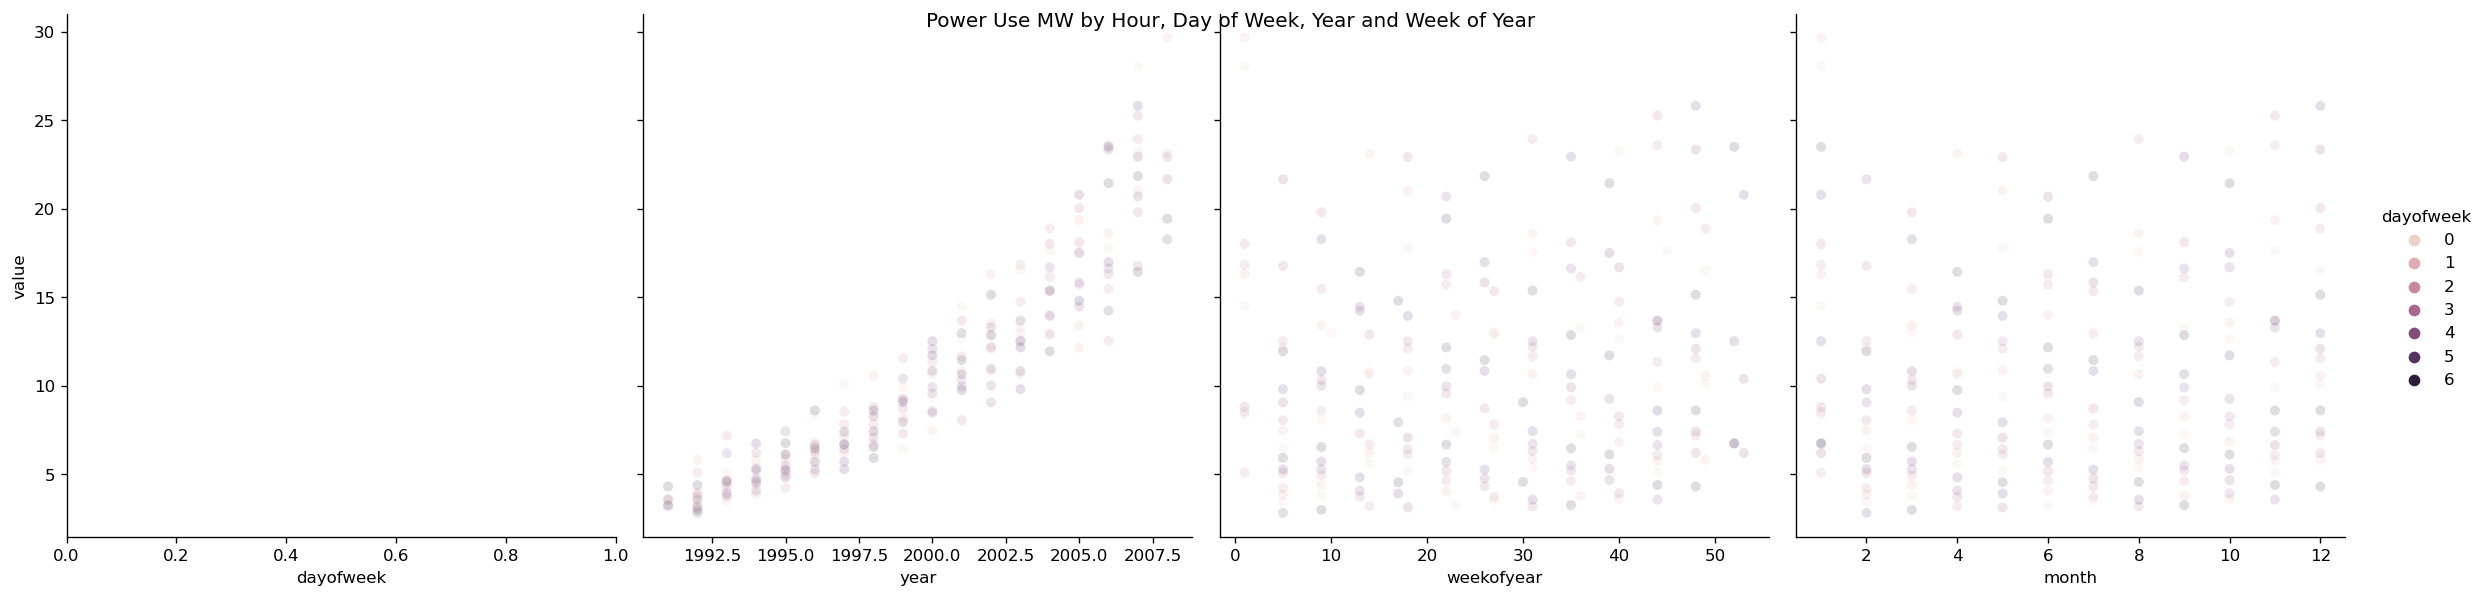

In [144]:
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear', 'month'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()


In [ ]:
# Tranfer the index using date
# df = df.set_index('DATE')
# df.index = pd.to_datetime(df.index)

In [148]:
# (float(df.loc[df['date'] == '2000-07-01']['value'])- float(df.loc[df['date'] == '1991-07-01']['value'])) / float(df.loc[df['date'] == '2000-07-01']['value'])

In [146]:
df.index

DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', length=204, freq=None)

<AxesSubplot:xlabel='date', ylabel='value'>

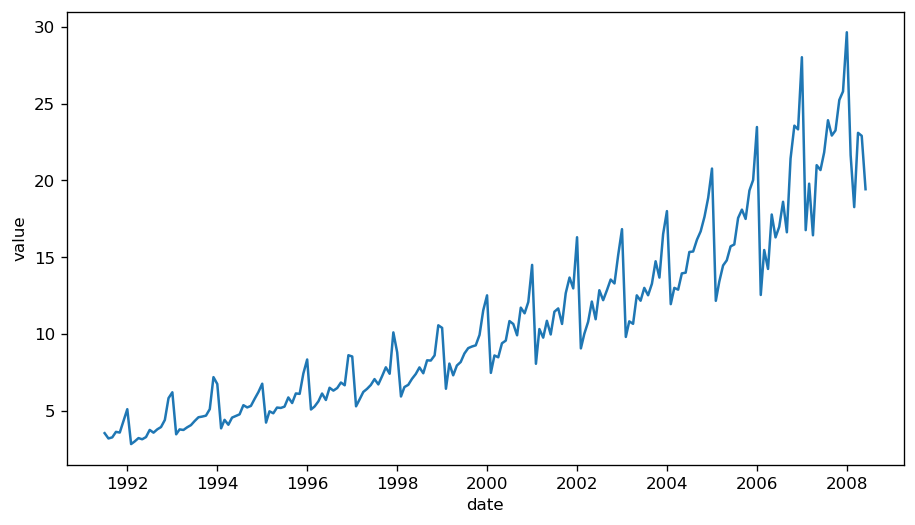

In [150]:
sns.lineplot(data=df, x=df.index, y=df.value)

What was the percent increase in value from Jan 2000 to Jan 2008?

In [156]:
100 * (df.loc['2008-01-01']['value'] - df.loc['2000-01-01']['value']) / df.loc['2008-01-01']['value']

57.82466810780899

What is the month with the least value/ highest after 2005

In [162]:
df.loc['2005-01-01':]['value'].idxmax()

Timestamp('2008-01-01 00:00:00')

In [163]:
df.loc['2005-01-01':]['value'].idxmin()

Timestamp('2005-02-01 00:00:00')

What 6 months have the highest value?

In [165]:
df.sort_values(by='value', ascending=False).head(5)

,value,year,month
date,,,
2008-01-01,29.665356,2008,Jan
2007-01-01,28.038383,2007,Jan
2007-12-01,25.806090,2007,Dec
2007-11-01,25.250030,2007,Nov
2007-08-01,23.930204,2007,Aug


How many millions of dollars in value was lost in 2007? (Another way of posing this question is what was the value difference between Jan 2007 and Jan 2008)

In [166]:
df.loc['2007-01-01']['value'] - df.loc['2008-01-01']['value']

-1.626972999999996

Create a bar plot showing the average value in millions of dollars per each month

<AxesSubplot:xlabel='month'>

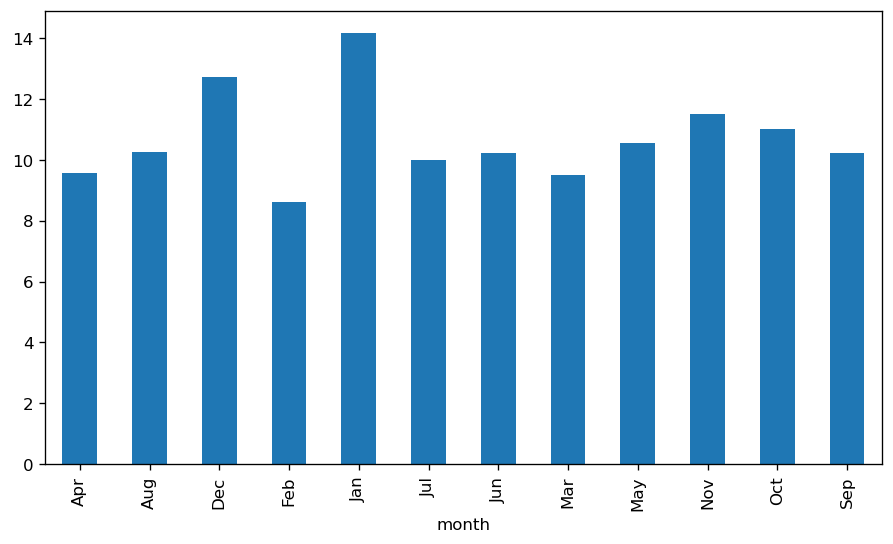

In [171]:
df.groupby(['month'])['value'].mean().plot.bar()

In [178]:
yearly_data = df.resample('Y').mean()
yearly_data_shift = yearly_data.shift(1)
yearly_data.head()

,value,year
date,,
1991-12-31,3.573824,1991
1992-12-31,3.807246,1992
1993-12-31,4.627724,1993
1994-12-31,5.068007,1994
1995-12-31,5.610550,1995


Plot out the yearly rolling mean on top of the original data. Recall that this is monthly data and there are 12 months in a year!

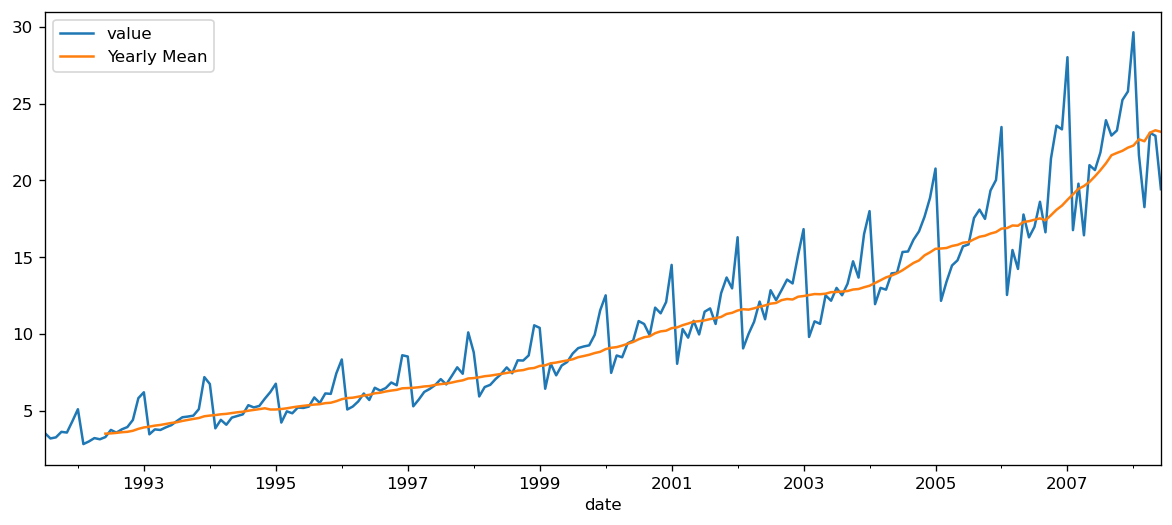

In [179]:
df['Yearly Mean'] = df['value'].rolling(window=12).mean()
df[['value','Yearly Mean']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

## Train/Test Split

In [180]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)
split_date = '01-01-2004'
train = df.loc[df.date <= split_date].copy()
test = df.loc[df.date > split_date].copy()
print(train.shape)
print(test.shape)

(151, 2)
(53, 2)


## Using Prophet

<a id='Prophet_'></a>

In [181]:
# Plot train and test so you can see where we have split
"""test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(train.rename(columns={'value': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='value vs year', style='.')
plt.show()"""

"test     .rename(columns={'value': 'TEST SET'})     .join(train.rename(columns={'value': 'TRAINING SET'}),\n          how='outer')     .plot(figsize=(15,5), title='value vs year', style='.')\nplt.show()"

In [182]:
# Format data for prophet model using ds and y
train.rename(columns={'date':'ds',
                     'value':'y'}).head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [183]:
model = Prophet()
model.fit(train.rename(columns={'date':'ds',
                     'value':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [184]:
test_fcst = model.predict(df=test.rename(columns={'date':'ds'}))

In [185]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-02-01,14.169619,11.789786,13.250802,14.169619,14.169619,-1.631876,-1.631876,-1.631876,-1.631876,-1.631876,-1.631876,0.0,0.0,0.0,12.537743
1,2004-03-01,14.257032,12.518356,13.991592,14.256611,14.257276,-1.006166,-1.006166,-1.006166,-1.006166,-1.006166,-1.006166,0.0,0.0,0.0,13.250866
2,2004-04-01,14.350474,12.732146,14.184916,14.349046,14.351907,-0.929330,-0.929330,-0.929330,-0.929330,-0.929330,-0.929330,0.0,0.0,0.0,13.421144
3,2004-05-01,14.440901,13.054285,14.506752,14.437578,14.443551,-0.670699,-0.670699,-0.670699,-0.670699,-0.670699,-0.670699,0.0,0.0,0.0,13.770202
4,2004-06-01,14.534343,12.936121,14.413450,14.529089,14.538608,-0.836141,-0.836141,-0.836141,-0.836141,-0.836141,-0.836141,0.0,0.0,0.0,13.698201


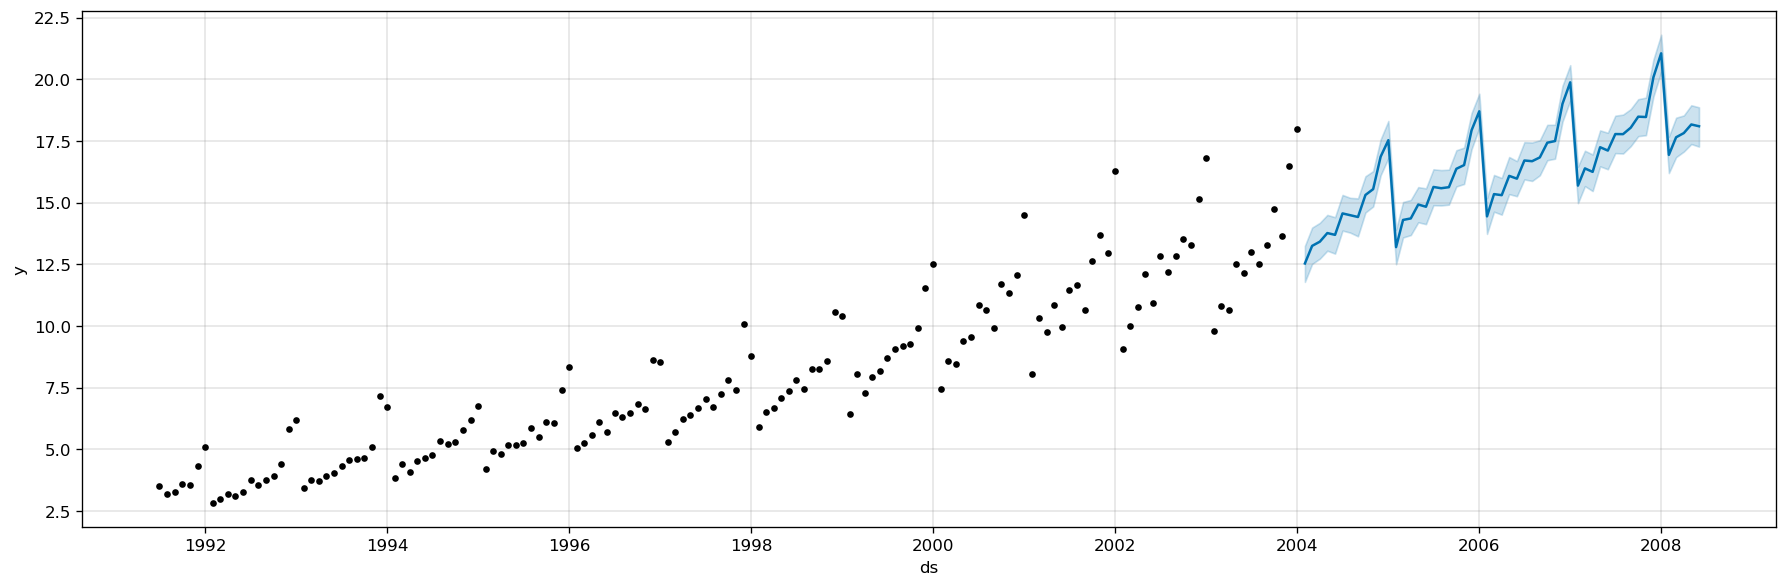

In [186]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

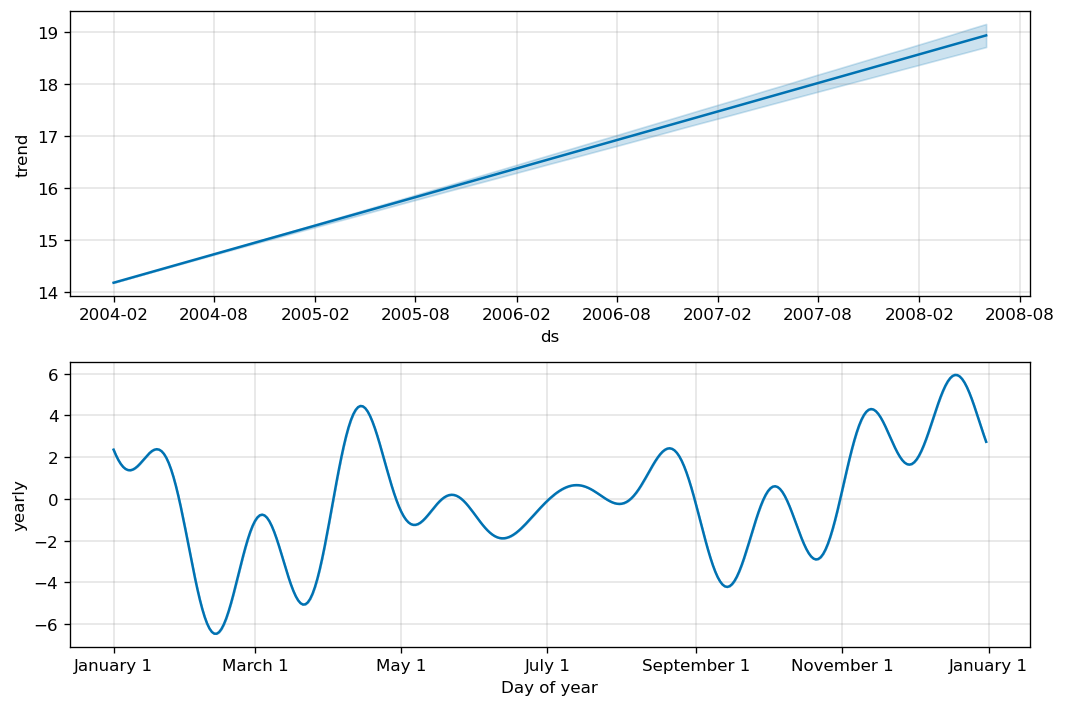

In [187]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

## Compare Forecast to Actuals

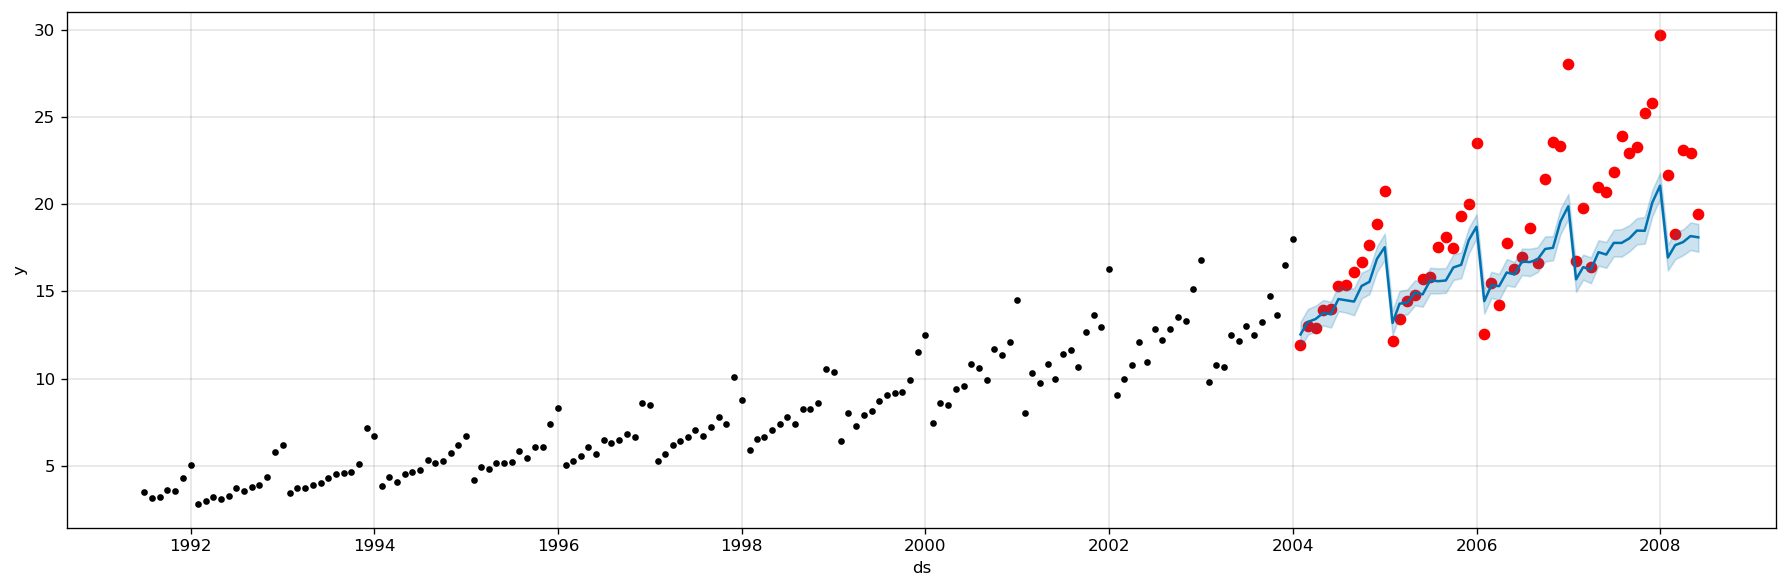

In [188]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.date, test['value'], color='r')
fig = model.plot(test_fcst, ax=ax)

## Look at first month of predictions

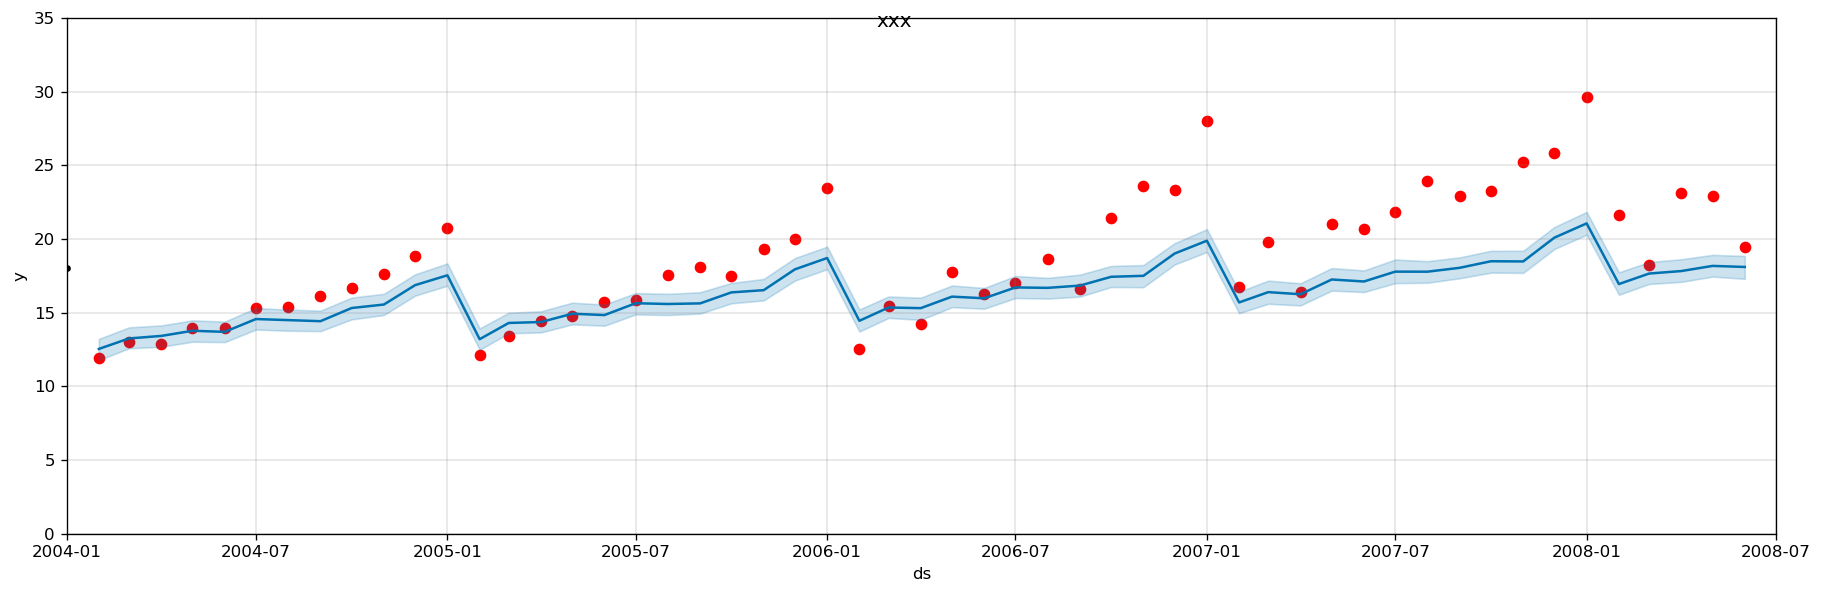

In [78]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.date, test.value, color='r')
fig = model.plot(test_fcst, ax=ax)
#ax.set_xbound(lower='01-02-2004',upper='01-02-2008')
ax.set_xlim(datetime.date(2004, 1, 1), datetime.date(2008, 7, 1))
ax.set_ylim(0, 35)
plot = plt.suptitle('xxx')

## Error Metrics

In [79]:
mean_squared_error(y_true=test['value'],
                   y_pred=test_fcst['yhat'])

11.176357180700839

In [80]:
mean_absolute_error(y_true=test['value'],
                   y_pred=test_fcst['yhat'])

2.4915858729215423

## Using Prophet to make predictions in the future

<a id='Using_Prophet_to_make_predictions_in_the_future_'></a>

In [81]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)
df.rename(columns={'date':'ds',
                     'value':'y'}, inplace=True)

In [82]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
future = m.make_future_dataframe(periods=24, freq='M')
future.tail()

,ds
223,2010-01-31
224,2010-02-28
225,2010-03-31
226,2010-04-30
227,2010-05-31


In [84]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
223,2010-01-31,25.457054,24.027825,26.793243
224,2010-02-28,26.148950,24.830918,27.487417
225,2010-03-31,23.847162,22.504634,25.140491
226,2010-04-30,27.333690,25.975584,28.722320
227,2010-05-31,27.544944,26.235521,28.929874


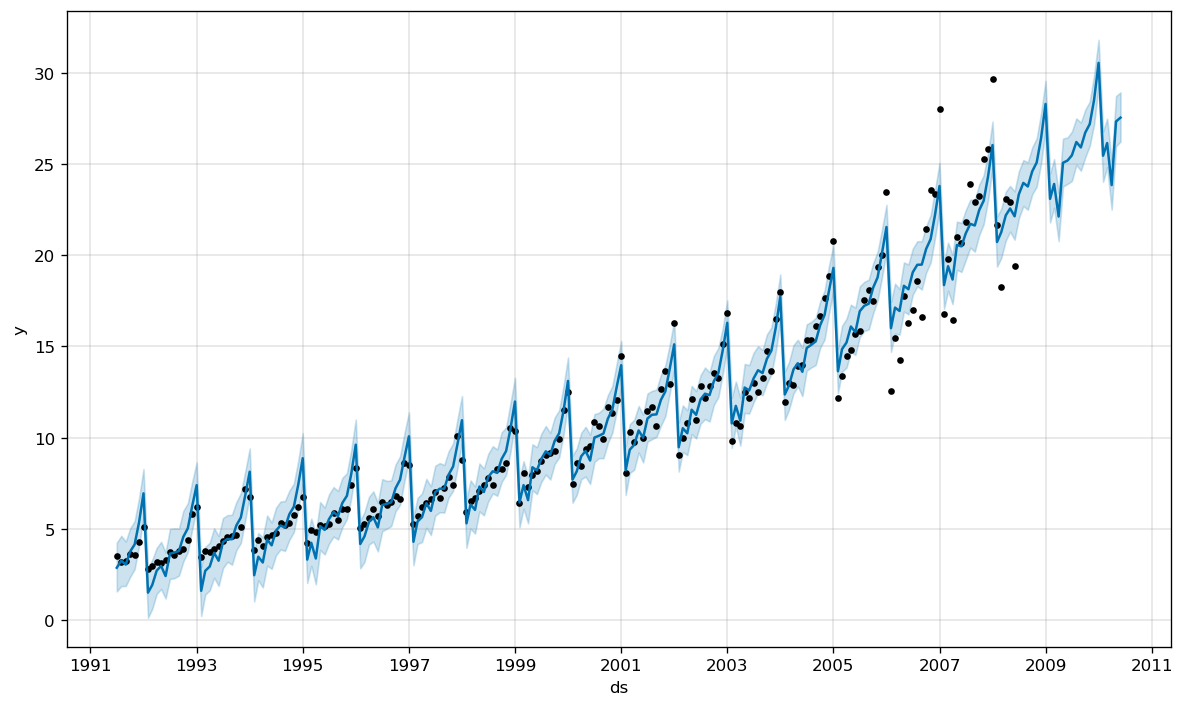

In [85]:
fig1 = m.plot(forecast)

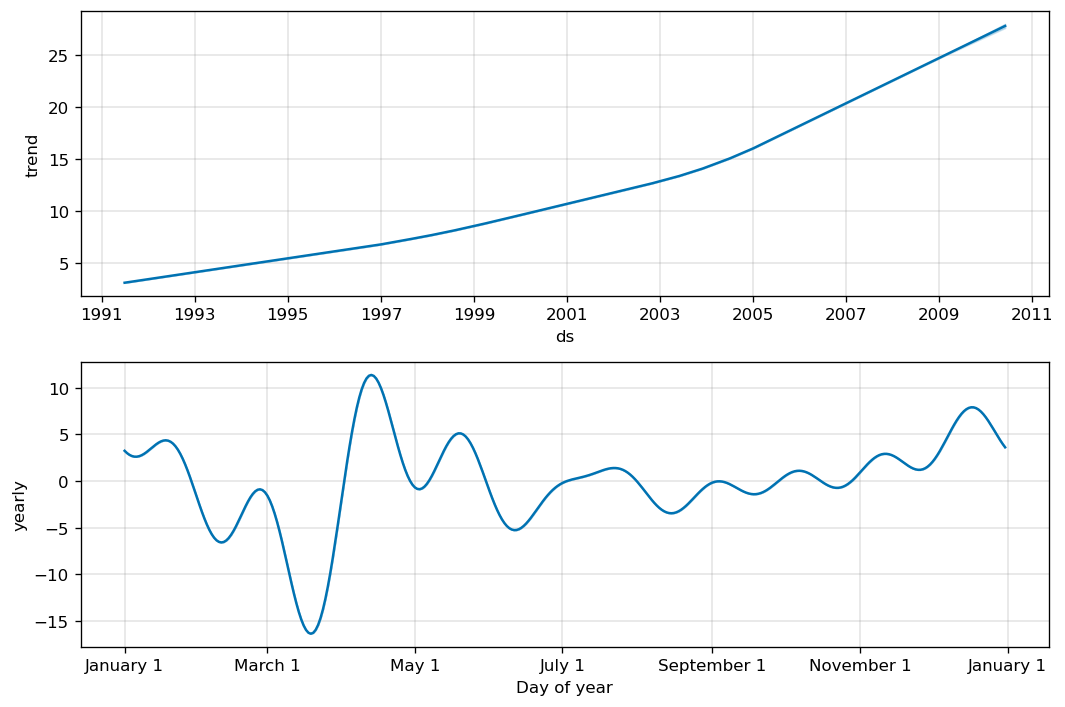

In [86]:
fig2 = m.plot_components(forecast)

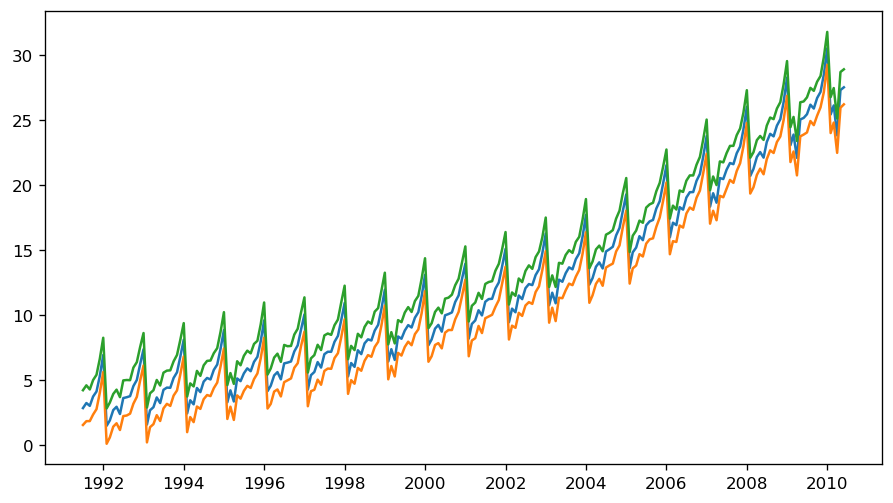

In [87]:
x1 = forecast['ds']
y1 = forecast['yhat']
y2 = forecast['yhat_lower']
y3 = forecast['yhat_upper']
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.plot(x1,y3)
plt.show()

## Statistics Model

<a id='Statistics_Model'></a>

In [196]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
split_date = '01-01-2004'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()
print(train.shape)
print(test.shape)

(151, 1)
(53, 1)


### Evaluating Model against Test Set

In [197]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [198]:
fitted_model = ExponentialSmoothing(train['value'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [199]:
test_predictions = fitted_model.forecast(36).rename('Forecast')
test_predictions

2004-02-01    10.314954
2004-03-01    11.739869
2004-04-01    11.758176
2004-05-01    13.350113
2004-06-01    12.732704
2004-07-01    14.103987
2004-08-01    13.715681
2004-09-01    14.050139
2004-10-01    15.440450
2004-11-01    15.023258
2004-12-01    17.142188
2005-01-01    19.074081
2005-02-01    10.976522
2005-03-01    12.492826
2005-04-01    12.512307
2005-05-01    14.206346
2005-06-01    13.549339
2005-07-01    15.008571
2005-08-01    14.595360
2005-09-01    14.951270
2005-10-01    16.430751
2005-11-01    15.986801
2005-12-01    18.241633
2006-01-01    20.297432
2006-02-01    11.680520
2006-03-01    13.294076
2006-04-01    13.314806
2006-05-01    15.117496
2006-06-01    14.418350
2006-07-01    15.971172
2006-08-01    15.531460
2006-09-01    15.910197
2006-10-01    17.484567
2006-11-01    17.012143
2006-12-01    19.411593
2007-01-01    21.599244
Freq: MS, Name: Forecast, dtype: float64

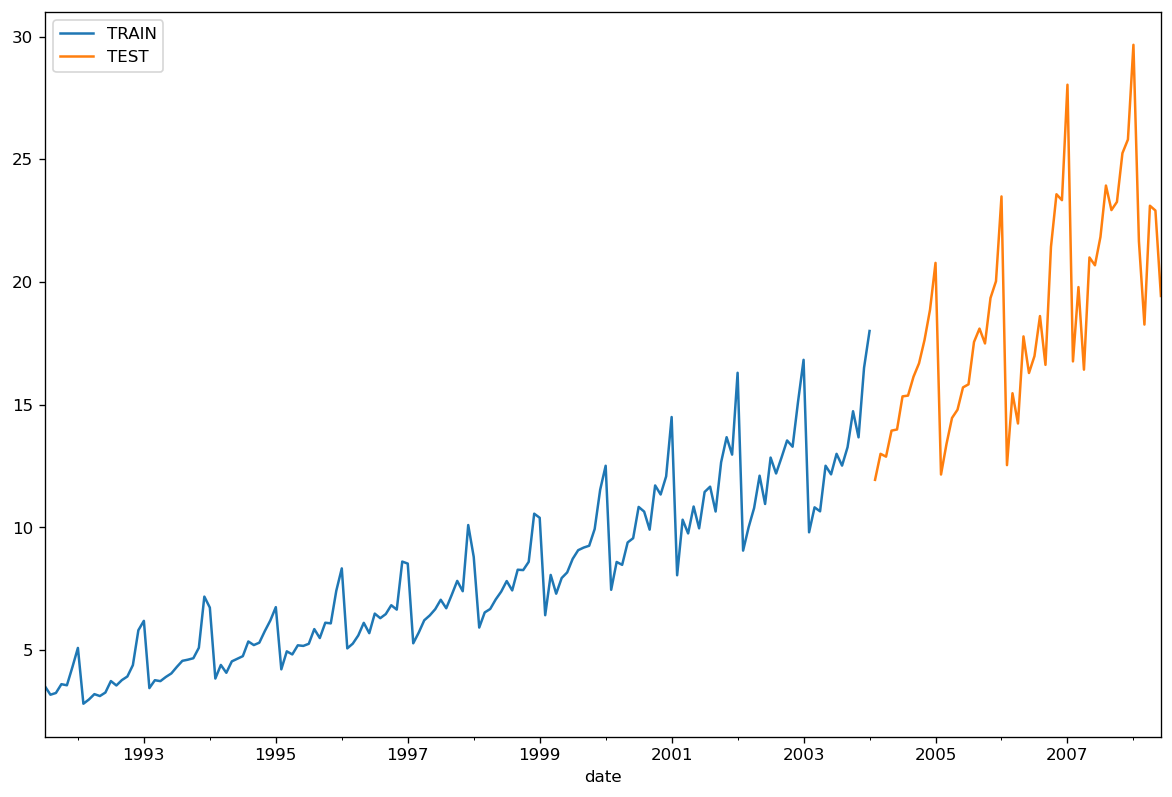

In [200]:
train['value'].plot(legend=True,label='TRAIN')
test['value'].plot(legend=True,label='TEST',figsize=(12,8))

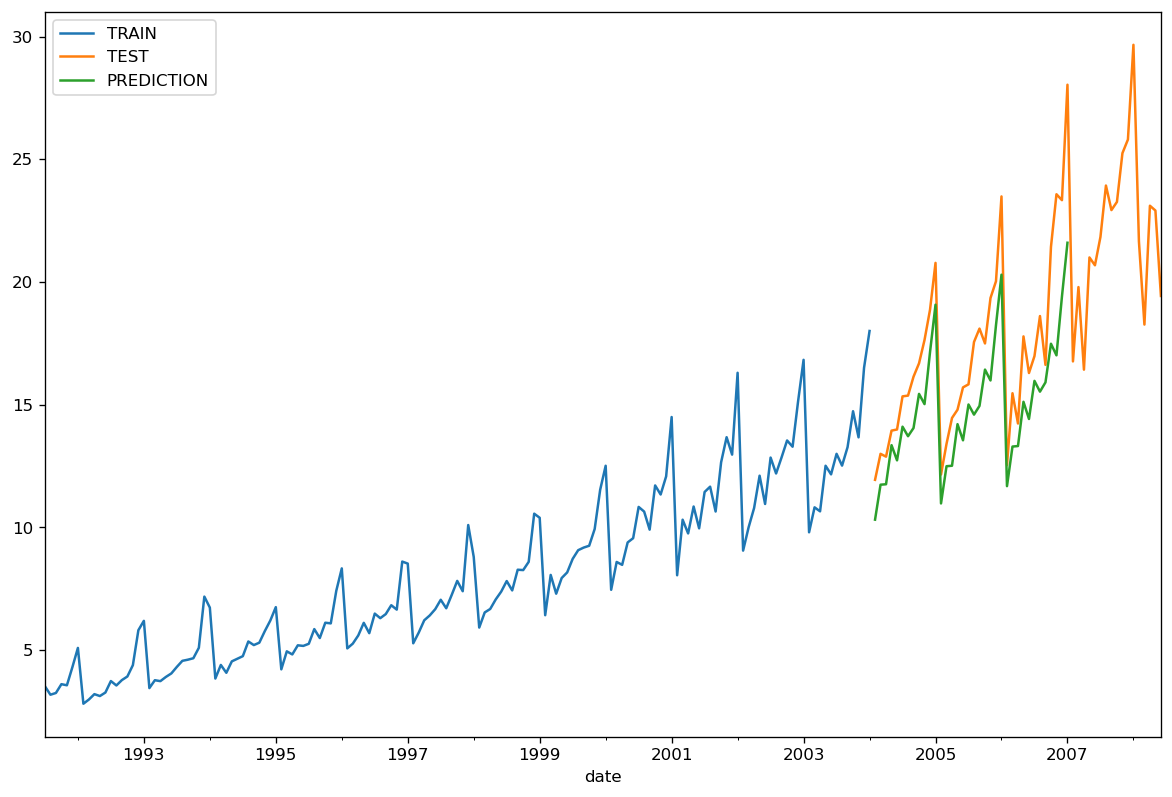

In [201]:
train['value'].plot(legend=True,label='TRAIN')
test['value'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

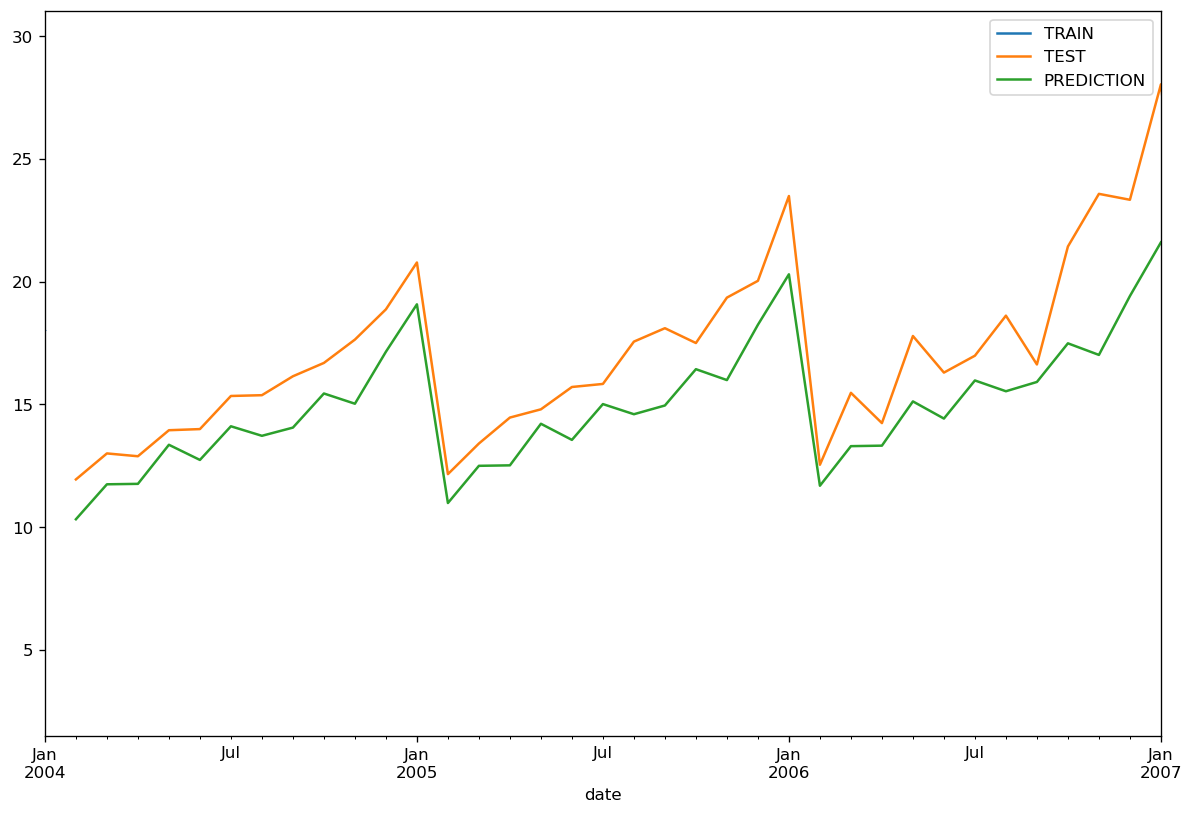

In [205]:
train['value'].plot(legend=True,label='TRAIN')
test['value'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2004-01-01','2007-01-01']);

## Forecasting into Future

In [206]:
final_model = ExponentialSmoothing(df['value'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [207]:
forecast_predictions = final_model.forecast(36)

<AxesSubplot:xlabel='date'>

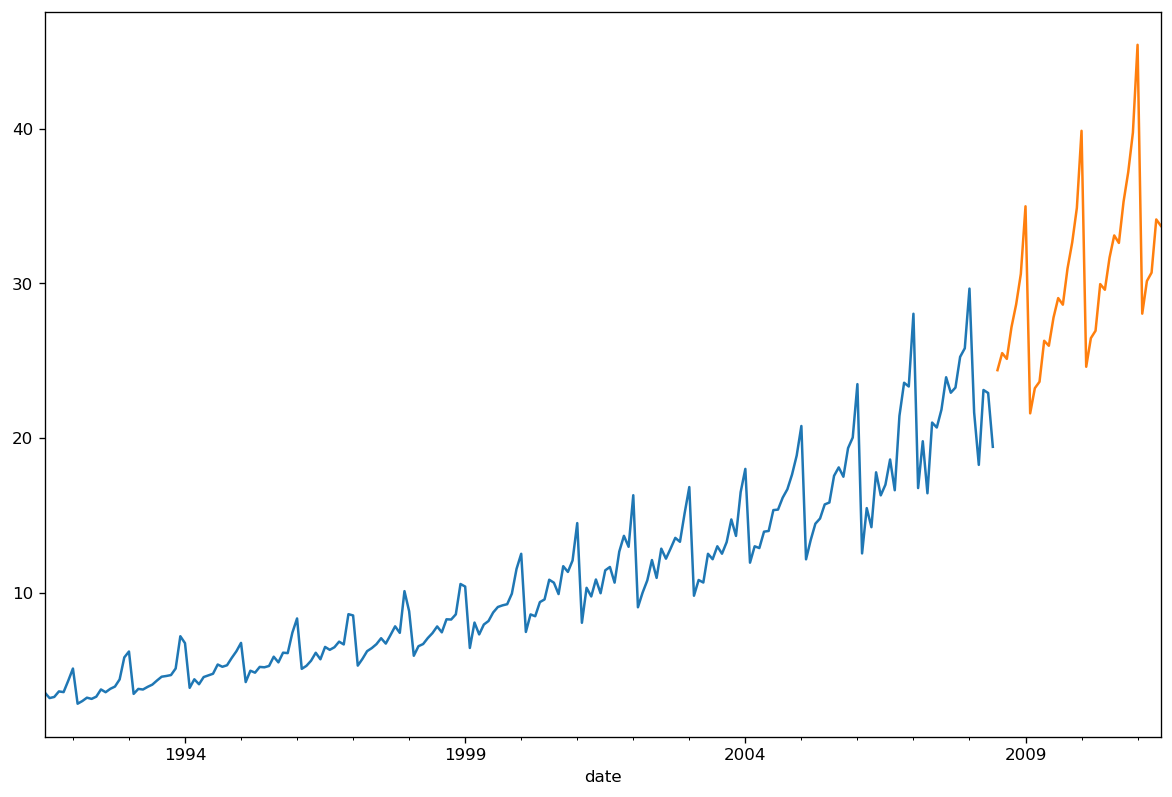

In [209]:
df['value'].plot(figsize=(12,8))
forecast_predictions.plot()

## ARIMA Model

<a id='ARIMA_'></a>

ARIMA, or Autoregressive Integrated Moving Average is actually a combination of 3 models:

- ARIMA stands for Autoregressive Integreted Moving Average
- ARIMA models are denoted with the notation ARIMA(p, d, q)
- These three parameters account for seasonality, trend, and noise in data

1. AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
2. I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
3. MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [36]:
from statsmodels.tsa.arima_model import ARIMA

In [37]:
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  203
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -417.781
Method:                       css-mle   S.D. of innovations              1.889
Date:                Fri, 20 Nov 2020   AIC                            845.561
Time:                        13:48:49   BIC                            862.127
Sample:                    08-01-1991   HQIC                           852.263
                         - 06-01-2008                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0964      0.017      5.655      0.000       0.063       0.130
ar.L1.D.value     0.4019      0.173      2.319      0.020       0.062       0.742
ma.L1.D.value    -1.0114      0.178     

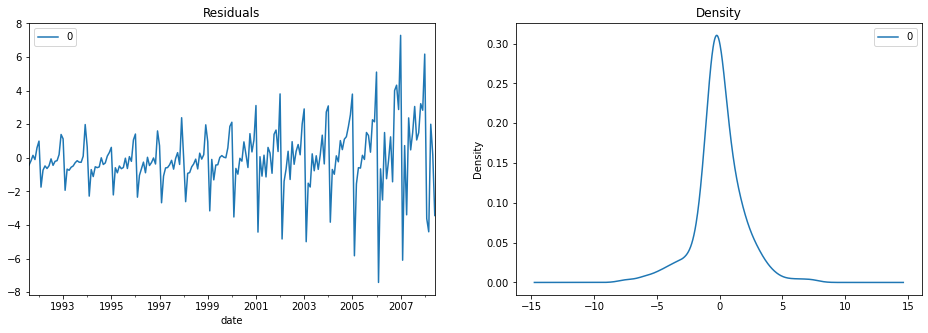

In [38]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(16, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

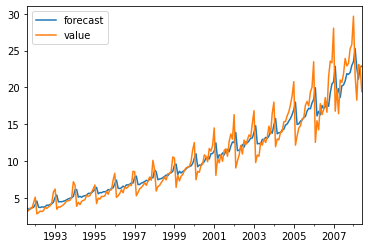

In [39]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [40]:
df.shape

(204, 1)

In [41]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:160]
test = df.value[160:]

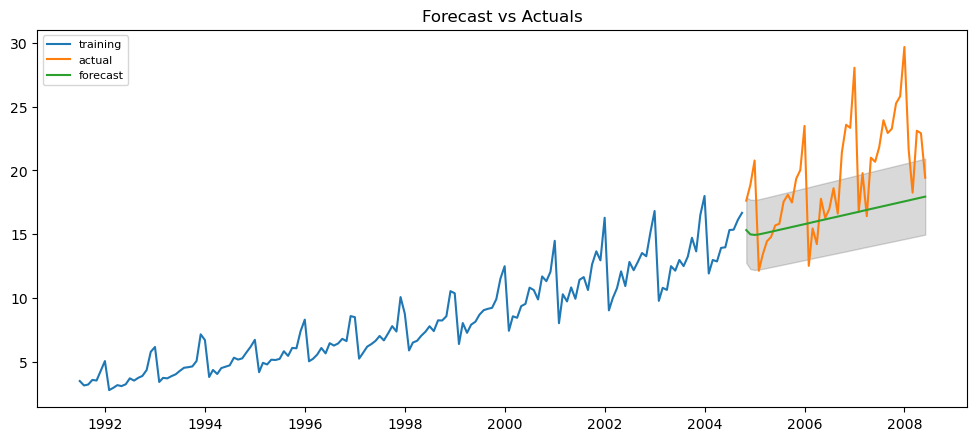

In [42]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(44, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  158
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -286.531
Method:                       css-mle   S.D. of innovations              1.453
Date:                Fri, 20 Nov 2020   AIC                            585.063
Time:                        13:48:51   BIC                            603.438
Sample:                    09-01-1991   HQIC                           592.525
                         - 10-01-2004                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0008      0.001      0.557      0.577      -0.002       0.003
ar.L1.D2.value    -0.4329      0.079     -5.499      0.000      -0.587      -0.279
ar.L2.D2.value    -0.2755      0.083

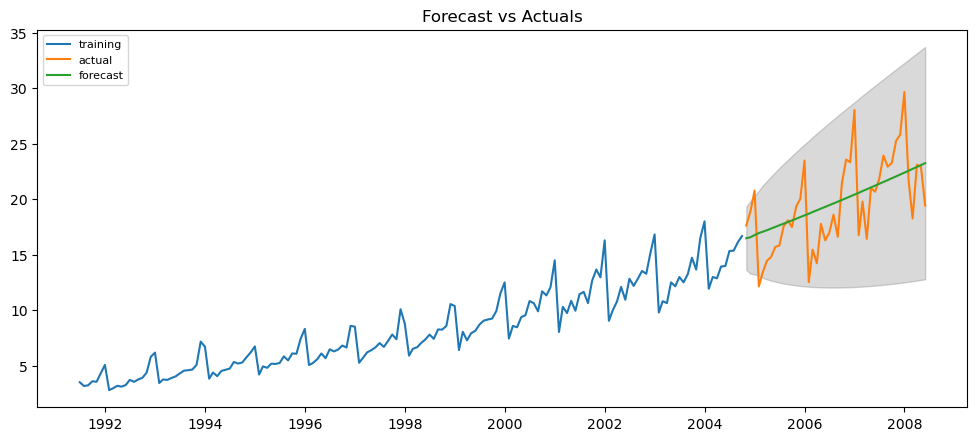

In [43]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(44, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Accuracy Metrics for Time Series Forecast

In [44]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.14055682737001113,
 'me': 0.2776827044678658,
 'mae': 2.577674699111057,
 'mpe': 0.044727728440487106,
 'rmse': 3.187748518356692,
 'acf1': 0.2944363634326145,
 'corr': 0.6216704966881437,
 'minmax': 0.12217533002443048}

## How to do Auto Arima Forecast in Python

In [45]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=3.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.578, Time=0.44 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

## How to interpret the residual plots in ARIMA model

In [46]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

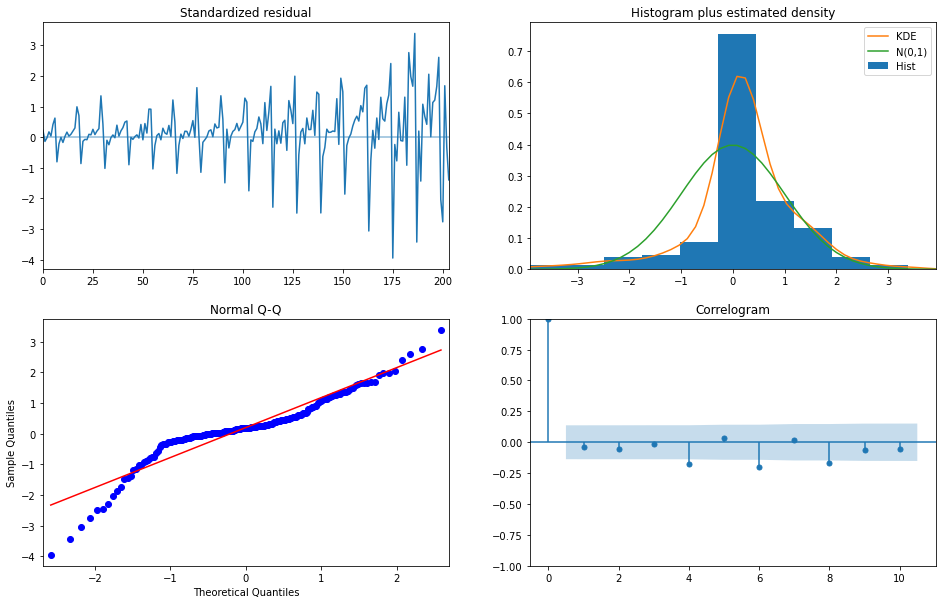

In [47]:
model.plot_diagnostics(figsize=(16,10))
plt.show()

In [48]:
fc

array([16.49170689, 16.57459394, 16.775024  , 16.95597888, 17.07451481,
       17.20992364, 17.35944702, 17.5086227 , 17.65304966, 17.79901416,
       17.94709047, 18.09593229, 18.24505873, 18.39496611, 18.54576597,
       18.69734257, 18.8496438 , 19.00270803, 19.15654968, 19.31115944,
       19.46653185, 19.62266975, 19.77957477, 19.93724619, 20.09568348,
       20.25488682, 20.41485639, 20.57559213, 20.737094  , 20.89936201,
       21.06239617, 21.22619647, 21.39076293, 21.55609552, 21.72219427,
       21.88905916, 22.0566902 , 22.22508738, 22.39425071, 22.56418019,
       22.73487581, 22.90633758, 23.07856549, 23.25155956])

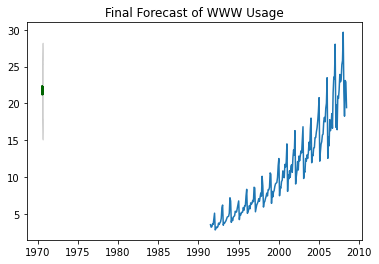

In [49]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

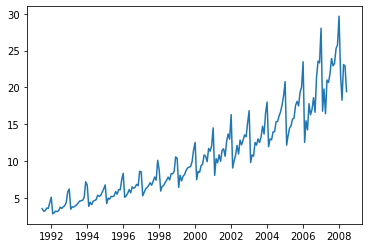

In [50]:
plt.plot(df.value)

## How to automatically build SARIMA model in python

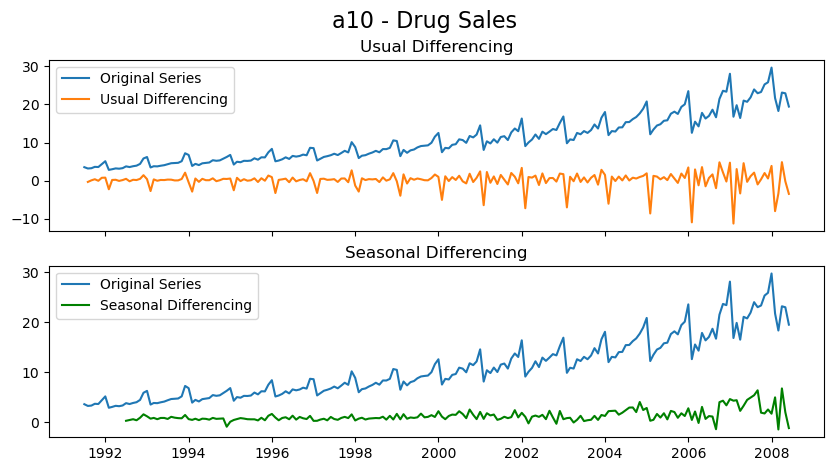

In [51]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [52]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=2.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.18 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=4.83 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.13 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=538.104, Time=4.82 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.28 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.12 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.26 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(1, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -251.643
Date:                                 Fri, 20 Nov 2020   AIC                            519.286
Time:                                         13:52:21   BIC                            545.345
Sample:                                              0   HQIC                           529.840
                                                 - 204                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9955      0.007    150.224      0.000       0.982       1.008
ma.L1         -1.0077      0.058    -17.475      0.000      -1.121      -0.895
ma.L2          0.4886      0.078      6.297      0.000       0.337       0.641
ma.L3         -0.2511      0.065     -3.893      0.000      -0.378      -0.125
ar.S.L12       0.8470      0.147      5.751      0.000       0.558       1.136
ma.S.L12      -1.6042      0.171     -9.367      0.000      -1.940      -1.269
ma.S.L24       0.7793      0.109      7.166      0.000       0.566       0.992
sigma2         0.7190      0.066     10.913      0.000       0.590       0.848
===================================================================================
Ljung-Box (Q):                       63.07   Jarque-Bera (JB):               228.26
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              14.55   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

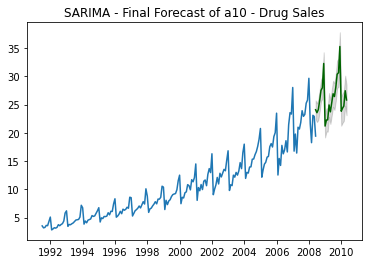

In [53]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

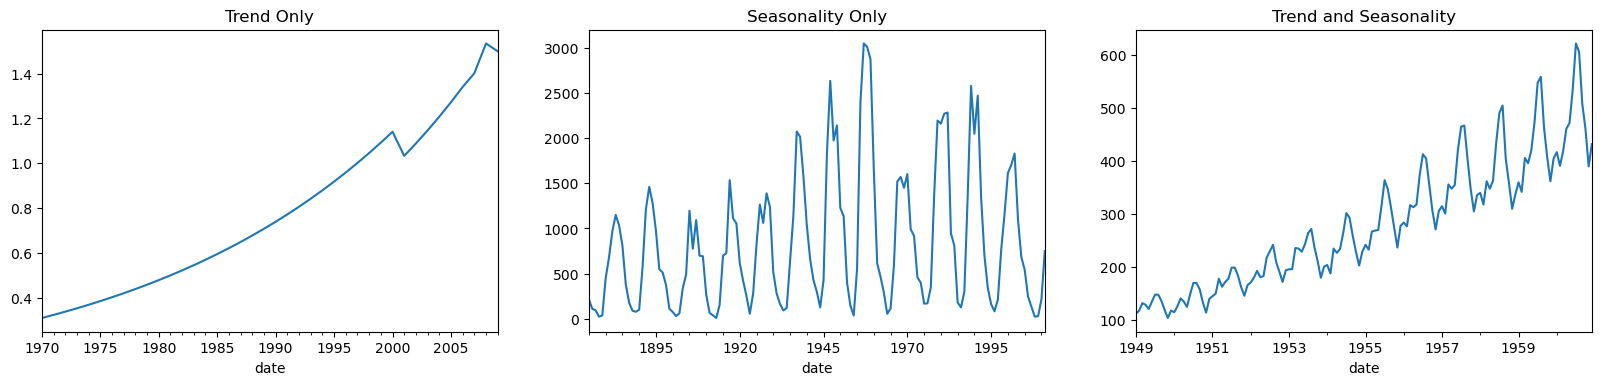

In [54]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

## How to decompose a time series into its components?

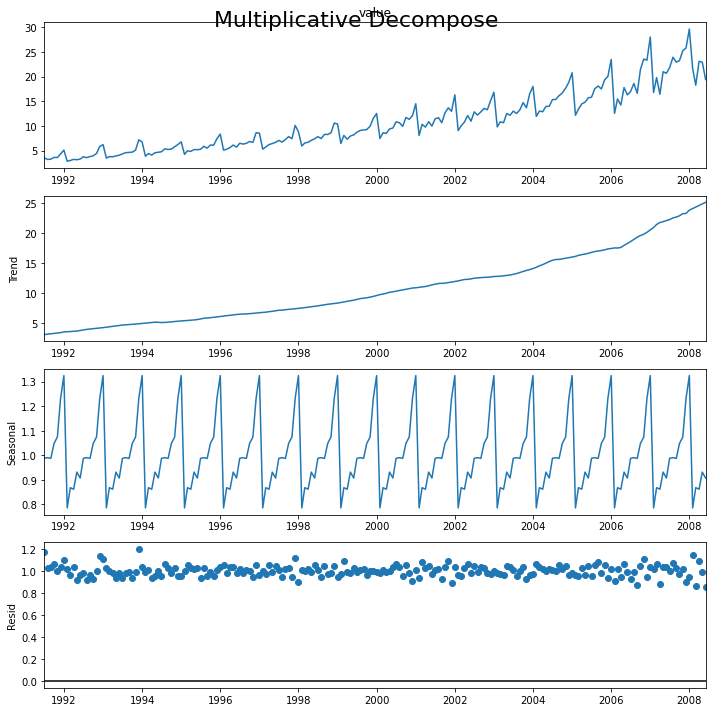

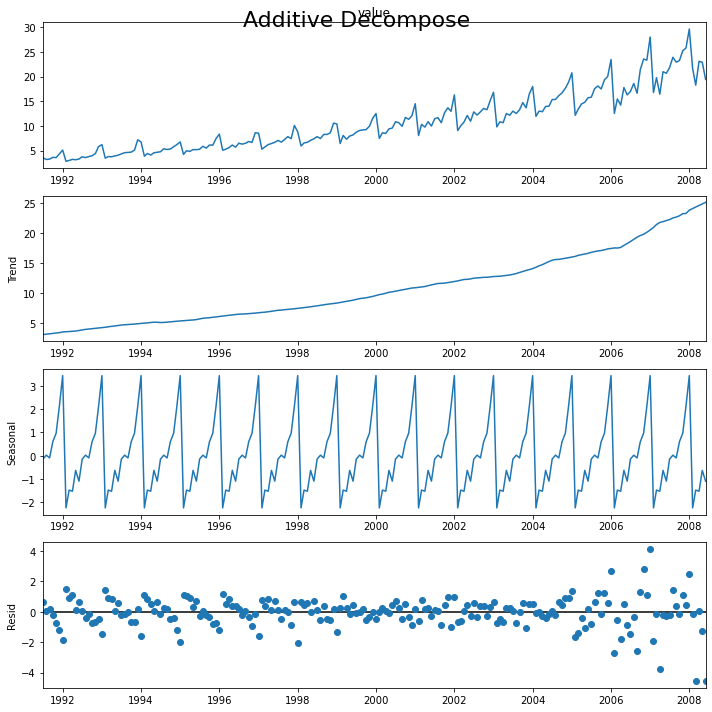

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [56]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


## Stationary and Non-Stationary Time Series

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time.

That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up.

A stationary time series id devoid of seasonal effects as well.

So how to identify if a series is stationary or not? Let’s plot some examples to make it clear:

## How to make a time series stationary?

Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.
You can make series stationary by:

1. Differencing the Series (once or more)
2. Take the log of the series
3. Take the nth root of the series
4. Combination of the above

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

So what is differencing?

If Y_t is the value at time ‘t’, then the first difference of Y = Yt – Yt-1. In simpler terms, differencing the series is nothing but subtracting the next value by the current value.

If the first difference doesn’t make a series stationary, you can go for the second differencing. And so on.

For example, consider the following series: [1, 5, 2, 12, 20]

First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]

Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]

## Why make a non-stationary series stationary before forecasting?

Forecasting a stationary series is relatively easy and the forecasts are more reliable.

An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.

We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

Now that we’ve established that stationarizing the series important, how do you check if a given series is stationary or not?

## How to test for stationarity?
The stationarity of a series can be established by looking at the plot of the series like we did earlier.

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

Nevertheless, you need a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.

There are multiple implementations of Unit Root tests like:

Augmented Dickey Fuller test (ADH Test)
Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
Philips Perron test (PP Test)
The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [57]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.14518568930673
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 1.313675
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


首先，我们将使用 Dickey-Fuller 检验，我将使用 5% 的基础 P 值，也就是说，如果 P 值低于 5% 这意味着这个序列在统计上是平稳的。
现在我们要用 KPSS 检验分析序列，与 Dickey-Fuller 检验不同，KPSS 检验已经假设序列是平稳的，只有当 P 值小于 5% 或统计检验小于某个临界值时，序列才不是平稳的

## How to test for seasonality of a time series?

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

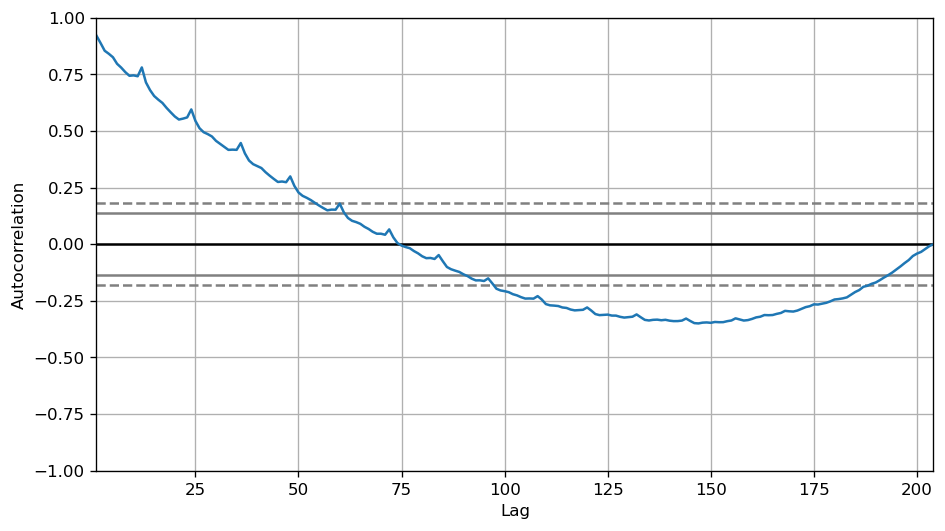

In [58]:
from pandas.plotting import autocorrelation_plot
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR